In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la 
import scipy.sparse.linalg as spla
import time 
import matplotlib.pyplot as plt

%matplotlib inline

### Problem 1. 
Write a function that accepts an $mxn$ matrix $A$ of rank $n$ and a vector $b$ of length $n$. Use the QR decomposition and Equation 4.1 to solve the normal equation corresponding to Ax = b.
You may use either SciPy’s QR routine or one of your own routines from the previous lab. In addition, you may use `la.solve_triangular()`, SciPy’s optimized routine for solving triangular systems.


In [2]:
def solve(A, b):
    Q, R = la.qr(A, mode = 'economic')
    #solve for Rx = (Q.T)b
    x = la.solve_triangular(R, np.dot(Q.T, b))
    return x

In [3]:
A = np.random.random((4,3))
b = np.random.random((4,1))

In [4]:
x = solve(A,b)
x

array([[-0.3522316 ],
       [ 1.14718802],
       [ 0.23169763]])

In [5]:
#rmse
np.sqrt(((np.dot(A,x) - b)**2).sum())

0.062224941940080672

### Problem 2.
The file `housing.npy` contains the purchase-only housing price index, a measure of how housing prices are changing, for the United States from 2000 to 2010.a Each row in the array is a separate measurement; the columns are the year and the price index, in that order. To avoid large numerical computations, the year measurements start at 0 instead of 2000.
Find the least squares line that relates the year to the housing price index (i.e., let year be the x-axis and index the y-axis).

1. Construct the matrix A and the vector b described by Equation 4.2. (Hint: the functions `np.vstack()`, `np.column_stack()`, and/or `np.ones()` may be helpful.)
2. Use your function from Problem 1 to find the least squares solution.
3. Plot the data points as a scatter plot.
4. Plot the least squares line with the scatter plot.

In [6]:
data = np.load("../Data/Volume1/housing.npy")

In [7]:
A = np.hstack((data[:,0, None], np.ones((len(data), 1))))
b = data[:,1, None]

In [8]:
x = solve(A,b)

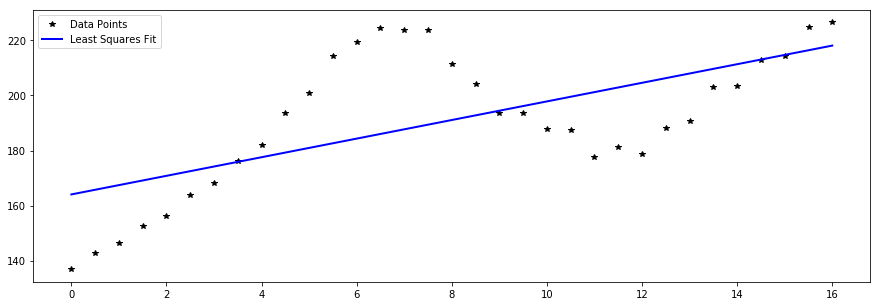

In [9]:
plt.figure(figsize=(15,5))
plt.plot(A[:,0], b, 'k*', label="Data Points")
plt.plot(A[:,0], np.dot(A,x), 'b-', lw=2, label="Least Squares Fit")
plt.legend(loc="upper left")

### Problem 3.
The data in housing.npy is nonlinear, and might be better fit by a polynomial than a line.
Write a function that uses Equation 4.3 to calculate the polynomials of degree 3, 6, 9, and 12 that best fit the data. Plot the original data points and each least squares polynomial together in individual subplots.
(Hint: define a separate, more refined domain with `np.linspace()` and use this domain to smoothly plot the polynomials.)


Instead of using Problem 1 to solve the normal equation, you may use `scipy.linalg.lstsq()`, demonstrated below.
Compare your results to `np.polyfit()`. This function receives an array of $x$ values, an array of $y$ values, and an integer for the polynomial degree, and returns the coefficients of the best fit polynomial of that degree.

In [10]:
def mypolyfit(x,b,deg):
    A = np.vander(x, N = deg+1)
    coeff,_,_,_ = la.lstsq(A, b)
    return A,coeff

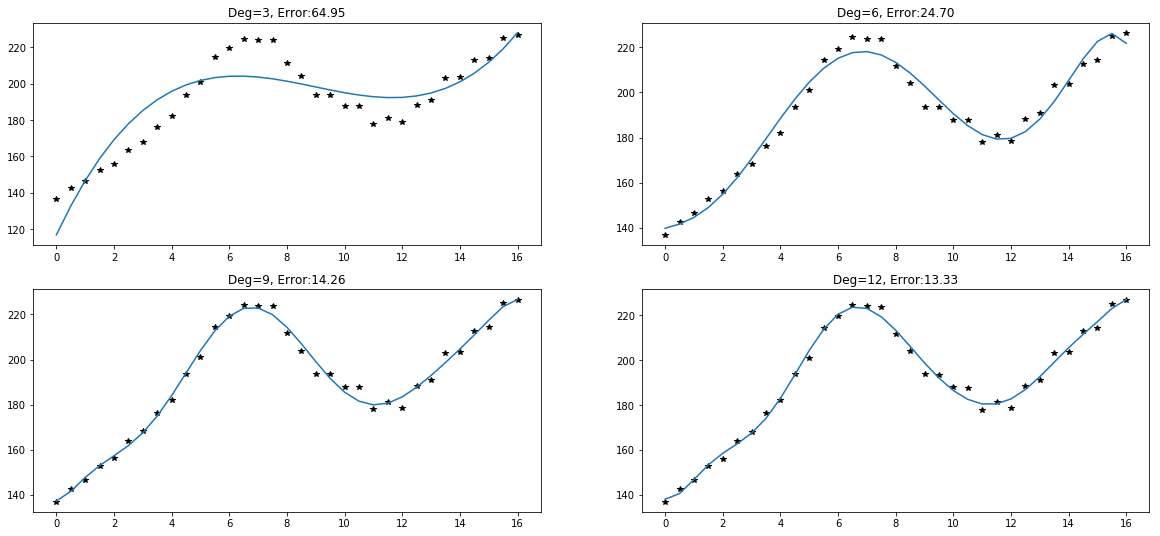

In [11]:
degs = [3,6,9,12]

fig,ax = plt.subplots(figsize=(20,9), nrows=2, ncols=2)
ax = ax.flatten()
for i,j in enumerate(degs):
    A_, coeff, = mypolyfit(A[:,0],b,j)
    ax[i].plot(A[:,0], b, 'k*')
    ax[i].plot(A[:,0], np.dot(A_, coeff))
    error = np.sqrt(((np.dot(A_, coeff) - b)**2).sum())
    ax[i].set_title("Deg=%i, Error:%.2f"%(j, error))

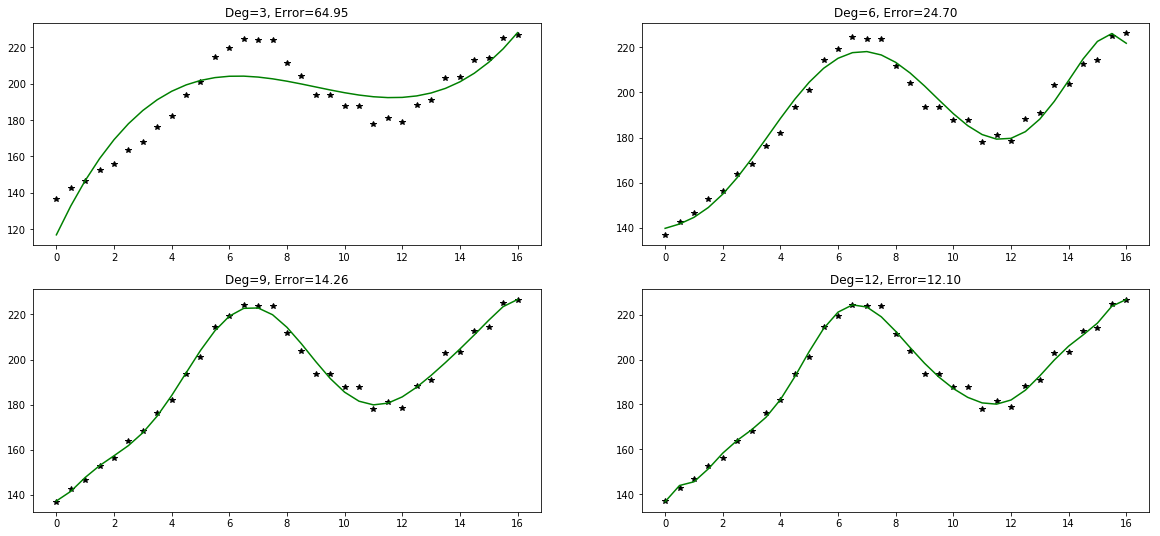

In [12]:
#np.polyfit()
fig,ax = plt.subplots(figsize=(20,9), nrows=2, ncols=2)
ax = ax.flatten()
for i,j in enumerate(degs):
    coeff = np.polyfit(A[:,0], b, deg=j)
    A_ = np.vander(A[:,0], N=j+1)
    ax[i].plot(A[:,0], b, 'k*')
    ax[i].plot(A[:,0], np.dot(A_, coeff), 'green')
    error = np.sqrt(((np.dot(A_, coeff) - b)**2).sum())
    ax[i].set_title("Deg=%i, Error=%.2f"%(j, error))

### Problem 4
The general equation for an ellipse is
$$ax^2 +bx+cxy+dy+ey^2 =1$$
Write a function that calculates the parameters for the ellipse that best fits the data in the file `ellipse.npy`. Plot the original data points and the ellipse together, using the following function to plot the ellipse.

In [13]:
ellipse_data = np.load("../Data/Volume1/ellipse.npy")

In [14]:
def ellipse(data):
    x,y = data[:,0], data[:,1]
    A = np.column_stack((x**2, x, x*y, y, y**2))
    b = np.ones((len(data), 1))
    coeff,_,_,_ = la.lstsq(A, b)
    return coeff

In [15]:
coeff_ellipse = ellipse(ellipse_data)

In [16]:
def plot_ellipse(a, b, c, d, e):
    """Plot an ellipse of the form ax^2 + bx + cxy + dy + ey^2 = 1."""
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A))/(2*A)
    plt.plot(r*cos_t, r*sin_t, lw=2)
    plt.gca().set_aspect("equal", "datalim")

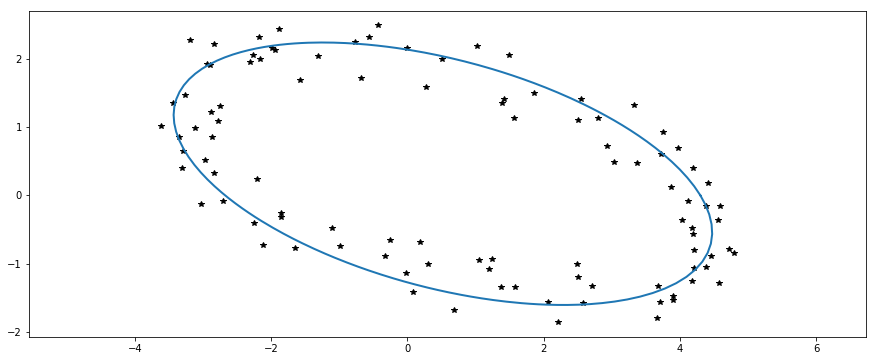

In [17]:
plt.figure(figsize=(15,6))
plt.plot(ellipse_data[:,0], ellipse_data[:,1], 'k*')
plot_ellipse(*coeff_ellipse)

### Computing Eigenvalues

### Problem 5 

Write a function that accepts an $n x n$ matrix $A$, a maximum number of iterations $N$, and a stopping tolerance $tol$. Use Algorithm 4.1 to compute the dominant eigenvalue of $A$ and a corresponding eigenvector.


Continue the loop in step 5 until either  $x_{k+1} - x_{k}$ is less than the tolerance tol, or until iterating the maximum number of times $N$.

Test your function on square matrices with all positive entries, verifying that $Ax = \lambda x$. Use SciPy’s eigenvalue solver, `scipy.linalg.eig()`, to compute all of the eigenvalues and corresponding eigenvectors of A and check that $\lambda$ is the dominant eigenvalue of A.

In [18]:
def power_method(A, N, tol):
    m,n = A.shape
    x0 = np.random.random(n)
    x0 /= np.linalg.norm(x0)
    small_diff = False
    k=0
    while k < N or not small_diff:
        xnext = np.dot(A,x0)
        xnext /= np.linalg.norm(xnext)
        if np.linalg.norm(xnext-x0)<tol:
            small_diff=True
        x0 = xnext
        k+=1
    return np.dot(x0.T,np.dot(A, x0)), x0

In [19]:
A = np.abs(np.random.random((3,3)))
lambda_, x = power_method(A, 10, 0.003)
print(lambda_, "\n")
print(x[:, None])

1.87052846279 

[[ 0.65549486]
 [ 0.55626736]
 [ 0.51077697]]


In [20]:
# scipy.linalg.eig()
eigs, vects = la.eig(A)
print(eigs[0], "\n")
print(vects[:,0, None])

(1.87052845927+0j) 

[[ 0.65549485+0.j]
 [ 0.55626744+0.j]
 [ 0.51077689+0.j]]


In [27]:
import cmath

In [30]:
def qr_eigs(A, N, tol):
    m,n = A.shape
    S = la.hessenberg(A)
    for k in range(N):
        Q,R = la.qr(S)
        S = np.dot(R,Q)
    eigs = []
    i = 0
    while i<n:
        if S[i,i]==S[m-1,n-1] or S[i+1,i]<tol:
            eigs.append(S[i,i])
        else:
            a = 1
            b = -S[i,i]*S[i+1,i+1]
            c = S[i,i]*S[i+1,i+1] - S[i,i+1]*S[i+1,i]
            eig1 = (-b + cmath.sqrt(b**2 - 4*a*c))/2*a
            eig2 = (-b - cmath.sqrt(b**2 - 4*a*c))/2*a
            eigs += [eig1, eig2]
            i +=1
        i+=1
    return eigs

In [53]:
A = np.random.random((3,3))
A = A+A.T

In [54]:
qr_eigs(A, 100, 0.004)

[3.1450627499229347, -0.74988631751988633, 0.47895242967277468]

In [55]:
list(la.eig(A)[0])

[(3.1450627499229338+0j), (-0.74988631751988633+0j), (0.47895242967277479+0j)]